# SEVIR Tutorial

The Storm EVent ImagRy (SEVIR) dataset is a collection of temporally and spatially aligned images containing weather events captured by satellite and radar.  This dataset was created using publically available datasets distributed by NOAA, including the [GOES-16 geostationary satellite](https://registry.opendata.aws/noaa-goes/), and data derived from [NEXRAD weather radars](https://registry.opendata.aws/noaa-nexrad/), both of which are available on the Registry of Open Data on AWS.  This tutorial provides information about the SEVIR dataset as well as code samples that can be used to access the data.

The animation below shows one of thousands of samples in the SEVIR dataset.   Each of these "events" consists of 4 hours of data in 5 minute time increments over a 384 km x 384 km patch sampled somewhere over the US.  Each event is SEVIR is captured by up to 5 sensors, or image types, described below.  

<p>
    <center><img src="tutorial_img/sevir_sample.gif" alt="sev_samp"/></center>
        <center><em>Figure 1:  Sample event in the SEVIR dataset.  SEVIR contains over 10,000 sets of image sequences similar to the one shown here.  </em> </center>
</p>

This tutorial includes the following: 

* [SEVIR Overview](#overview)
* [Data organization](#files)
* [Accessing SEVIR Data](#access)
* [Georeferencing SEVIR Events](#geo)
* [Additional resources](#additional)



###### SEVIR Overview <a class="anchor" id="overview"></a>

There is no shortage of weather data available to the public: Weather radar, GEO & LEO satellite, surface observations, numerical weather prediction models, balloons, ocean buoys, aircraft measurements, lightning sensing, radio occultation, and others are being measured every second of every day to aid in our ability to analyze and forecast the weather.  As a result, both the size and complexity of all of this data can make it difficult to work with.  Many datasets, such as radar and satellite, are too large to process in bulk for those without access to massive compute and storage.  Some datasets also require a level of domain expertise to decode, understand and process.  These are some of the barriers for scientists and researchers who want to understand and use this data for their applications.  

To help alleviate these issues, the SEVIR dataset was constructed to enable faster R&D in weather sensing, avoidance, short-term forecasting and other related applications.  SEVIR combines and aligns multiple weather sensing modalities into a single, accessible dataset accessible for free on the cloud that can be used by meteorologists, data scientists and other researchers.  

SEVIR is a collection of thousands of "events", which are 4-hour sequences of weather captured by up to 5 sensors.   These 5 sensing modalities are summarized in the table below:


| Sensor | Data key | Description | Spatial Resolution |  Patch Size |  Time step | Sample Colorized Image |
|:--------:|:------:|:-------------:|:--------------------:|:---------:|:-----------:|:------:|
|  GOES-16 C02 0.64 $\mu m$  |`vis`  |  Visible satellite imagery |  0.5 km | 768x768 | 5 minute   |      <img src="tutorial_img/vis_sample.png" width="80" height="80" />        |
|  GOES-16 C09 6.9 $\mu m$  |`ir069`   |  Infrared Satellite imagery (Water Vapor) | 2 km | 192 x 192  | 5 minutes         |     <img src="tutorial_img/ir069_sample.png" width="80" height="80" />        |
|  GOES-16 C13 10.7 $\mu m$  |`ir107`   |  Infrared Satellite imagery (Window) | 2 km | 192 x 192  | 5 minutes         |     <img src="tutorial_img/ir107_sample.png" width="80" height="80" />        |
|  Vertically Integrated Liquid (VIL) |`vil`   |  NEXRAD radar mosaic of VIL | 1 km | 384 x 384  | 5 minutes         |     <img src="tutorial_img/vil_sample.png" width="80" height="80" />        |
|  GOES-16 GLM flashes |`lght`   |  Detections of inter cloud and cloud to ground lightning events | 8 km | N/A  | Continuous   |     <img src="tutorial_img/lght_sample.png" width="80" height="80" />        |

<p>
    <center><em>Table 1:  Description of sensor types in SEVIR. </em></center>
</p>

Four of the five sensor types listed above (`vis`,`ir069`,`ir107` & `vil`) are raster (image) types.  Their data is represented as a sequence of single channel (gray scale) images.  Each 4 hour event corresponding to these these data types are represented as a `L x L x 49` tensor, where `L` is the image size given in the Patch Size column above.  The last dimension of length 49 represents the time dimension of the data, which is consistent across all samples.  Additional information on working with these images is given below.

The lightning type `lght` is not stored as an image, but rather as a collection of discrete events.  This lightning data for an event is represented by an `Nx5` matrix, that contains information about flash time and location.  Additional details are provided below.


### Connection to NOAA's Storm Event Database

Many of the events in SEVIR can augmented using data collected by the National Weather Service (NWS).  Approximately 20% of the cases in SEVIR were selected 
based on tagged "Storm Events" logged by the National Weather Service (NWS) which are archived here: https://www.ncdc.noaa.gov/stormevents/.  This database includes additional information including:

* Type of severe weather (e.g. high winds, tornado, hail, etc..)
* Storm impacts (damage, injuries and deaths)
* Narrative summarizing the event.

For example, below is one entry from the NWS Storm Events database linked to the event depicted in Figure 1.  This represents one row from a CSV file whose columns are described [here](https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Export-Format.pdf)

```
StormEvents_details-ftp_v1.0_d2019_c20191217.csv:
201904,30,1452,201904,30,1454,137733,827433,"ILLINOIS",17,2019,"April","Tornado","C",135,"MONTGOMERY","LSX","30-APR-19 14:52:00","CST-6","30-APR-19 14:54:00","0","0","0","0","0.00K","0.00K","Storm Chaser",,,,,"EF0","1.17","25",,,,,"1","N","DONNELLSON","2","NE","DONNELLSON","39.0456","-89.4682","39.0517","-89.4478","As a warm front lifted northward through the region, widespread showers and thunderstorms developed. Some of the storms produced severe weather including large hail and a couple of tornadoes. The activity persisted into the early morning hours of May 1st, but no reports of severe weather occurred with this event on May 1st.","Several storm chasers witnessed a weak short-lived tornado from different vantage points. The tornado lifted dust from a field and small branches and leaves from a few trees. The location is estimated from a combination of radar and chaser reports. The tornado was rated EF0 with a path length of 1.17 miles and a max path width of 25 yards. There were no deaths or injuries reported with this tornado.","CSV"
```

As can be seen, this text data includes descriptions of time and location of a tornado, and a summary of the event.

Each event in SEVIR is assigned a unique `id`, e.g. `S827433`.  All SEVIR `id`'s beginning with an `S` are associated with an NWS Storm Event.  The number following `S` in the SEVIR id is the Event ID used in the NWS Storm Event database.  The remaining events in SEVIR that are not directly linked to NWS storm events were selected randomly from throughout the Continental US.  These randomly selected cases have `id`'s that begin with `R`, e.g. `R18032414177862`. 



## Data organization <a class="anchor" id="files"></a>



This section provides descriptions and code samples of how to access, visualize and work with SEVIR data.

SEVIR contains two major components:  

*  Catalog:    A CSV file with rows describing the metadata of an event
*  Data Files:       A set of HDF5 files containing events for a certain sensor type
 
We described each component separately below.

### Catalog

The data catalog is contained in the file named `CATALOG.csv`.  Each row of this file represents a single event captured by one of the sensor types listed in Table 1.  The columns of the catalog are as follows:

| Column | Description |
|------|-------------|
|   `id`     |      Unique id given to each *event* in SEVIR.  Note that up to 5 rows of the catalog may posses this ID, since each event may be captured by up to 5 of the sensor types listed in Table 1.      |
|   `file_name`     |     Name of the HDF5 file containing the image data.        |
|   `file_index`     |    File index within `file_name` where the data is located         |
|   `img_type`     |       Image or sensor type from the "Data key" column in Table 1     |
| `time_utc` |  UTC Timestamp of the event, which typically corresponds to the middle frame in the event  |
| `minute_offsets` |  Colon separated values denoting time offset in minutes of each frame relative to `time_utc`  |
| `episode_id` |  Storm Event `EPISODE_ID` associated to the SEVIR event (NWS Storm Events only) (see Note 1) |
| `event_id` |  Storm Event `EVENT_ID` associated to the SEVIR event (NWS Storm Events only) (see Note 1) |
| `llcrnrlat` | Latitude of the lower left corner   |
|`llcrnrlon` | Longitude  of the lower left corner|
|`urcrnrlat` | Latitude of the upper right corner |
|`urcrnrlon` | Longitude of the upper right corner|
|`proj` |  Proj4 string describing the map projection of the image (See Note 2) |
|`size_x` | X Size of the images in pixels |
|`size_y` | Y Size of the images in pixels|
|`height_m` | X Size of the images in meters |
|`width_m` | Y Size of the images in meters|
|`data_min` | Minimum data value across all frames of the event|
|`data_max` | Maximum data value across all frames of the event|
|`pct_missing` | Percentage of missing values across all the frames|

<p>
    <center><em>Table 2: SEVIR Catalog columns </em></center>
</p>


Notes:
    
1. There may additional Storm Event IDs that overlap with the 4 hour event in SEVIR.  The catalog will only provide one such IDs.  Others can be found by comparing the time and locations of the Storm Event with the metadata of the SEVIR event. 

2. All projections (currently) in SEVIR are Lambert Azmuthial Equal Area. This column exists incase future data use a different projection.  


### Data Files

The image data in SEVIR is stored in a collection of several [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) files.  These files are organized in the following directory structure

```
data
+-- img_type
|   +-- year  
```

The filenames of the data are formatted as follows:

```
SEVIR_<IMG_TYPE>_<EVENT_TYPE>_<YEAR>_<START>_<END>.h5
```

Where 

`<TYPE>` is the image or sensor type (`vil`, `vis`, `ir069`, etc..), 

`<EVENT_TYPE>` is either `STORMEVENTS`, if the events are linked with NWS storm events, `RANDOMEVENTS`, if the events are randomly sampled, or `ALLEVENTS` if the two types are mixed into the same file.

`<YEAR>_<START>_<END>`  Denotes the year, start date and end date of the events in the file.

Each file contains the `id`'s of the events, as well as the event data.  For example a summary of one such file is:

```bash
$ h5ls SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5
id                       Dataset {793}
vil                      Dataset {793, 384, 384, 49}
```

All raster types in SEVIR (`vis`, `ir069`, `ir107` & `vil`) store the data 4D tensors with shapes `N x L x W x T`,
where `N` is the number of events in the file,  `LxL` is the image size (see patch size column in Table 1), and `T` is the number of time steps in the image sequence.  



#### Decoding SEVIR data

For efficient storage, data is saved in HDF files as an integer type.  Depending on the sensor type, these integers can be decoded into floating type so they represent the actual values captured by each sensor type.  This decoding is done using either a simple linear scaling, or using an exponential transformation, as described below.

The satellite images (`vis`,`ir069` and `ir107`) use a linear scaling to encode their values.  To convert the integer data stored in the file to floating types, apply the formula  

```
decoded_data = encoded_data * SCALING_FACTOR
```

where `SCALING FACTOR` is provided in the following table, along with the units of the decoded data:


| Type | `SCALING_FACTOR` | Decoded units |
|:------:|:-------------:|:-------:|
| `vis` | 1e-4 | Reflectance factor |
| `ir069` | 1e-2 |  Degrees C |
| `ir107` | 1e-2 |  Degrees C |

<p>
    <center><em>Table 3: SEVIR linear scaling factors </em> </center>
</p>


The `vil` images in SEVIR are stored as integers in the range 0-255.  It is often convenient to work directly with these encoded units.  To convert these into units of $kg/m^2$, which are the true units of [vertically integrated liquid](https://en.wikipedia.org/wiki/Vertically_integrated_liquid), apply the following rule:

```
0                        if X <= 5
(X - 2) / 90.66          if 5 < X <= 18
exp( X - 83.9 ) / 38.9   if X > 18
```
Where `X` is the integer value stored in the HDF file.  This non-linear scaling rule was developed to make better use of the range 0-255 for storing VIL.  The reason for this is that VIL data exhibits histograms that quite skewed, and the non-linear encoding provides better precision and lessens the skewness.



#### Lightning Data 

The `lght` data is the only non-raster type in SEVIR (currently).  This data is stored in the HDF using the SEVIR `id` as a key.   Associated to each `id` is an `N x 5` matrix describing each 4 hour event.  Each row of this matrix represents a single [lightning flash identified by the GOES-16 GLM sensor](http://rammb.cira.colostate.edu/training/visit/quick_guides/GLM_Quick_Guide_Detection_Methods_June_2018.pdf).  The columns of this matrix are described in the following table:

| Column index | Meaning |
|------|-------------|
| 0 | Time of flash in seconds relative to `time_utc` column in the catalog. |
| 1 | Reported latitude of flash in degrees |  
| 2 | Reported longitude of flash in degrees |  
| 3 | Flash X coordinate when converting to raster|
| 4 | Flash Y coordinate when converting to raster |

<p>
    <center><em>Table 3: Description of columns for `lght` type </em> </center>
</p>

The `X` and `Y` coordinates of the flash are used when converting the flash data into raster format (see more information below).


## Accessing SEVIR Data  <a class="anchor" id="access"></a>

This section includes code samples for working with SEVIR data.    SEVIR data can downloaded and accessed from local storage, or through Amazon's S3 cloud storage.  This tutorial will assume SEVIR data was downloaded onto a local or network file system.  The examples below require the following variables to be set:

In [1]:
# Enter path to the SEVIR data location
DATA_PATH    = '../data'
CATALOG_PATH = '../CATALOG.csv' 

# On some Linux systems setting file locking to false is also necessary:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE' 

#### Example 1:   Accessing an event

The following code shows how to open a data file directly without using the catalog to visualize frames of an event captured by a single type using the `h5py` module:

Event ID: b'S728503'
Image shape: (384, 384, 49)


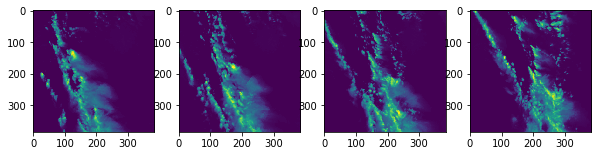

In [2]:
import os
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt
 
file_index = 0
with h5py.File('%s/vil/2018/SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5' % DATA_PATH,'r') as hf:
    event_id = hf['id'][file_index]
    vil      = hf['vil'][file_index] 
    
print('Event ID:',event_id)
print('Image shape:',vil.shape)

fig,axs=plt.subplots(1,4,figsize=(10,5))
axs[0].imshow(vil[:,:,10])
axs[1].imshow(vil[:,:,20])
axs[2].imshow(vil[:,:,30])
axs[3].imshow(vil[:,:,40])
plt.show()

#### Example 2:  Accessing multiple image types using the catalog 

The catalog can be used to easily obtain event data captured by multiple sensor types.  The catalog can be grouped on the `id` column to locate all available sensors for each event.  Since that some events in SEVIR are not covered by all sensors, so it is also necessary to filter out events that aren't covered by all requested image types.

The code below shows how to extract an event observed by four image types: `vis`, `vil`, `ir069` and `ir107`


In [3]:
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt
import pandas as pd  

# Read catalog
catalog = pd.read_csv(CATALOG_PATH,parse_dates=['time_utc'],low_memory=False)

# Desired image types
img_types = set(['vis','ir069','ir107','vil'])

# Group by event id, and filter to only events that have all desired img_types
events = catalog.groupby('id').filter(lambda x: img_types.issubset(set(x['img_type']))).groupby('id')
event_ids = list(events.groups.keys())
print('Found %d events matching' % len(event_ids),img_types)

# Grab a sample event and view catalog entries
sample_event = events.get_group( event_ids[-1])
print('Sample Event:',event_ids[-1])
sample_event

Found 13131 events matching {'vil', 'ir107', 'vis', 'ir069'}
Sample Event: S858968


,id,file_name,file_index,img_type,time_utc,minute_offsets,episode_id,event_id,event_type,llcrnrlat,...,urcrnrlat,urcrnrlon,proj,size_x,size_y,height_m,width_m,data_min,data_max,pct_missing
33195,S858968,vis/2019/SEVIR_VIS_STORMEVENTS_2019_0901_0930.h5,75,vis,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,768,768,384000.0,384000.0,0.033034,1.115368,0.0
46414,S858968,ir107/2019/SEVIR_IR107_STORMEVENTS_2019_0701_1...,543,ir107,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,192,192,384000.0,384000.0,-68.275558,20.554308,0.0
47327,S858968,ir069/2019/SEVIR_IR069_STORMEVENTS_2019_0701_1...,544,ir069,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,192,192,384000.0,384000.0,-68.739433,-23.089878,0.0
51277,S858968,vil/2019/SEVIR_VIL_STORMEVENTS_2019_0701_1231.h5,421,vil,2019-09-17 19:54:00,-119:-114:-109:-104:-99:-94:-89:-84:-79:-74:-6...,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384,384,384000.0,384000.0,0.000000,254.000000,0.0
75345,S858968,lght/2019/SEVIR_LGHT_ALLEVENTS_2019_0901_1001.h5,0,lght,2019-09-17 19:54:00,NaN,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,48,48,384000.0,384000.0,0.000000,446638.000000,0.0


This data frame contains rows for each of the image types in SEVIR corresponding to the listed `id`.  The following code uses rows of `sample_event` to extract image data for each type:

(<matplotlib.image.AxesImage at 0x14574765d2d0>, Text(0.5, 1.0, 'VIL'))

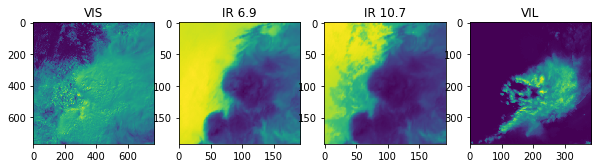

In [4]:
def read_data( sample_event, img_type, data_path=DATA_PATH ):
    """
    Reads single SEVIR event for a given image type.
    
    Parameters
    ----------
    sample_event   pd.DataFrame
        SEVIR catalog rows matching a single ID
    img_type   str
        SEVIR image type
    data_path  str
        Location of SEVIR data
    
    Returns
    -------
    np.array
       LxLx49 tensor containing event data
    """
    fn = sample_event[sample_event.img_type==img_type].squeeze().file_name
    fi = sample_event[sample_event.img_type==img_type].squeeze().file_index
    with h5py.File(data_path + '/' + fn,'r') as hf:
        data=hf[img_type][fi] 
    return data

vis = read_data(sample_event, 'vis')
ir069 = read_data(sample_event, 'ir069')
ir107 = read_data(sample_event, 'ir107')
vil = read_data(sample_event, 'vil')

# plot a frame from each img_type
fig,axs = plt.subplots(1,4,figsize=(10,5))
frame_idx = 30
axs[0].imshow(vis[:,:,frame_idx]), axs[0].set_title('VIS')
axs[1].imshow(ir069[:,:,frame_idx]), axs[1].set_title('IR 6.9')
axs[2].imshow(ir107[:,:,frame_idx]), axs[2].set_title('IR 10.7')
axs[3].imshow(vil[:,:,frame_idx]), axs[3].set_title('VIL')


#### Example 3:  Including Lightning

To include lightning in the data gathered in Example 2, we first need to convert it to a raster type to display it along with the other image types.  The following code achieves this by converting the flash data into flash counts per pixel per 5 minute frame:


(<matplotlib.image.AxesImage at 0x145747040190>, Text(0.5, 1.0, 'Lightning'))

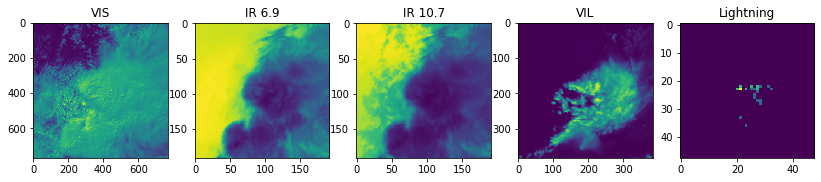

In [5]:
import numpy as np
def lght_to_grid(data):
    """
    Converts SEVIR lightning data stored in Nx5 matrix to an LxLx49 tensor representing
    flash counts per pixel per frame
    
    Parameters
    ----------
    data  np.array
       SEVIR lightning event (Nx5 matrix)
       
    Returns
    -------
    np.array 
       LxLx49 tensor containing pixel counts
    """
    FRAME_TIMES = np.arange(-120.0,125.0,5) * 60 # in seconds
    out_size = (48,48,len(FRAME_TIMES))
    if data.shape[0]==0:
        return np.zeros(out_size,dtype=np.float32)

    # filter out points outside the grid
    x,y=data[:,3],data[:,4]
    m=np.logical_and.reduce( [x>=0,x<out_size[0],y>=0,y<out_size[1]] )
    data=data[m,:]
    if data.shape[0]==0:
        return np.zeros(out_size,dtype=np.float32)

    # Filter/separate times
    # compute z coodinate based on bin locaiton times
    t=data[:,0]
    z=np.digitize(t,FRAME_TIMES)-1
    z[z==-1]=0 # special case:  frame 0 uses lght from frame 1

    x=data[:,3].astype(np.int64)
    y=data[:,4].astype(np.int64)

    k=np.ravel_multi_index(np.array([y,x,z]),out_size)
    n = np.bincount(k,minlength=np.prod(out_size))
    return np.reshape(n,out_size).astype(np.float32)

def read_lght_data( sample_event, data_path=DATA_PATH ):
    """
    Reads lght data from SEVIR and maps flash counts onto a grid  
    
    Parameters
    ----------
    sample_event   pd.DataFrame
        SEVIR catalog rows matching a single ID
    data_path  str
        Location of SEVIR data
    
    Returns
    -------
    np.array 
       LxLx49 tensor containing pixel counts for selected event
    
    """
    fn = sample_event[sample_event.img_type=='lght'].squeeze().file_name
    id = sample_event[sample_event.img_type=='lght'].squeeze().id
    with h5py.File(data_path + '/' + fn,'r') as hf:
        data      = hf[id][:] 
    return lght_to_grid(data)

lght = read_lght_data(sample_event)

# include lightning counts in plot
fig,axs = plt.subplots(1,5,figsize=(14,5))
frame_idx = 30
axs[0].imshow(vis[:,:,frame_idx]), axs[0].set_title('VIS')
axs[1].imshow(ir069[:,:,frame_idx]), axs[1].set_title('IR 6.9')
axs[2].imshow(ir107[:,:,frame_idx]), axs[2].set_title('IR 10.7')
axs[3].imshow(vil[:,:,frame_idx]), axs[3].set_title('VIL')
axs[4].imshow(lght[:,:,frame_idx]), axs[4].set_title('Lightning')



#### Example 3b. Adding some color

Example 3 used the default colormap to display the data.  To display colorized images similar to those seen in Figure 1, colormaps are available in the repo located here: https://github.com/MIT-AI-Accelerator/eie-sevir.  This code requires the module `sevir` found in this repo to be in your path:

(<matplotlib.image.AxesImage at 0x14573c1445d0>, Text(0.5, 1.0, 'Lightning'))

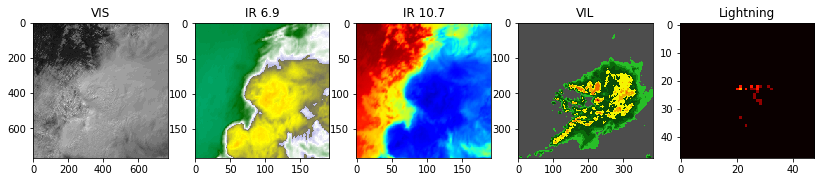

In [6]:
import sys
sys.path.append('../') # add sevir module to path
from sevir.display import get_cmap
# Get colormaps for encoded types
vis_cmap,vis_norm,vis_vmin,vis_vmax = get_cmap('vis',encoded=True)
ir069_cmap,ir069_norm,ir069_vmin,ir069_vmax = get_cmap('ir069',encoded=True)
ir107_cmap,ir107_norm,ir107_vmin,ir107_vmax = get_cmap('ir107',encoded=True)
vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)
lght_cmap,lght_norm,lght_vmin,lght_vmax = get_cmap('lght',encoded=True)

fig,axs = plt.subplots(1,5,figsize=(14,5))
frame_idx = 30
axs[0].imshow(vis[:,:,frame_idx],cmap=vis_cmap,norm=vis_norm,vmin=vis_vmin,vmax=vis_vmax), axs[0].set_title('VIS')
axs[1].imshow(ir069[:,:,frame_idx],cmap=ir069_cmap,norm=ir069_norm,vmin=ir069_vmin,vmax=ir069_vmax), axs[1].set_title('IR 6.9')
axs[2].imshow(ir107[:,:,frame_idx],cmap=ir107_cmap,norm=ir107_norm,vmin=ir107_vmin,vmax=ir107_vmax), axs[2].set_title('IR 10.7')
axs[3].imshow(vil[:,:,frame_idx],cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax), axs[3].set_title('VIL')
axs[4].imshow(lght[:,:,frame_idx],cmap=lght_cmap,norm=lght_norm,vmin=lght_vmin,vmax=lght_vmax), axs[4].set_title('Lightning')


## Georeferencing SEVIR Events  <a class="anchor" id="geo"></a>

In many applications it's necessary to know the lat/lon positions of pixels in a SEVIR patch.  The catalog provides the required information to perform the georeferencing the data.

Currently, all patches in SEVIR use the same map projection, a Lambert Equal Area projection centered at (lat,lon)=(38,-98).  This specifics of the projection are stored in the `proj` column:


In [7]:
sample_event.proj.values[0]

'+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=6370997.0 +ellps=sphere '

This string uses the [Proj4](https://proj.org/usage/index.html) syntax for defining a map projection.

The class below encodes the formulas for this particular projection.  Using this, it's possible to convert between pixel and lat/lon coordinates for each event in SEVIR.  

In [8]:
import re
import numpy as np
class LaeaProjection():
    """
    Translates between pixel coordinates (X,Y) and Lat lon coordinates for a given SEVIR event
    projected in laea.
    
    Parameters
    ----------
    event  pd.Series
        One row from SEVIR catalog
    """
    def __init__(self,event):
        self.proj = event.proj 
        self.lat0 = float(re.compile('\+lat_0=([+-]?\d+)').search(self.proj).groups()[0])
        self.lon0 = float(re.compile('\+lon_0=([+-]?\d+)').search(self.proj).groups()[0])
        self.R = float(re.compile('\+a=(\d+)').search(self.proj).groups()[0])
        self.llcrnlat = event.llcrnrlat
        self.llcrnlon = event.llcrnrlon
        self.refX, self.refY = self.forward(self.llcrnlon,self.llcrnlat,pixel=False)
        self.binX = event.width_m / event.size_x
        self.binY = event.height_m / event.size_y
        
    def forward(self,lon,lat,pixel=True):
        """
        Maps lat/lon to pixel x,y.  For projection coordinates instead of pixel, set pixel=False.
        """
        sind = lambda t: np.sin(t*np.pi/180)
        cosd = lambda t: np.cos(t*np.pi/180)
        k = self.R * np.sqrt(2/(1+sind(self.lat0)*sind(lat)+cosd(self.lat0)*cosd(lat)*cosd(lon-self.lon0)))
        x = k*cosd(lat)*sind(lon-self.lon0)
        y = k*(cosd(self.lat0)*sind(lat) - sind(self.lat0)*cosd(lat)*cosd(lon-self.lon0))
        if pixel:
            x = (x-self.refX) / self.binX
            y = (y-self.refY) / self.binY
        return x,y
    def inverse(self,x,y,pixel=True):
        """
        Maps pixel coordinates to (lon,lat) position.  If passing projection corrdinates, set pixel=False.
        """
        if pixel:
            x = x*self.binX + self.refX
            y = y*self.binY + self.refY
        x/=self.R
        y/=self.R
        sind = lambda t: np.sin(t*np.pi/180)
        cosd = lambda t: np.cos(t*np.pi/180)
        rho = np.sqrt(x*x+y*y)
        c = 2*np.arcsin(0.5*rho)
        sinc = np.sin(c)
        cosc = np.cos(c)
        lat = 180/np.pi*np.arcsin(cosc*sind(self.lat0)+y*sinc*cosd(self.lat0)/rho)
        lon = self.lon0+180/np.pi*np.arctan(x*sinc/(rho*cosd(self.lat0)*cosc - y*sind(self.lat0)*sinc))
        return lon,lat
        

#### Example 4:   Georeferencing an event

Using this class, we can get a grid of latitudes and longitudes for the grids in Examples 2 & Example 3.  Note that when we plot the images in this cell, we set `origin='lower'` so that the positive y dimension corresponds with increasing latitudes (i.e. northward)

Text(0.5, 1.0, 'Pixel Longitudes')

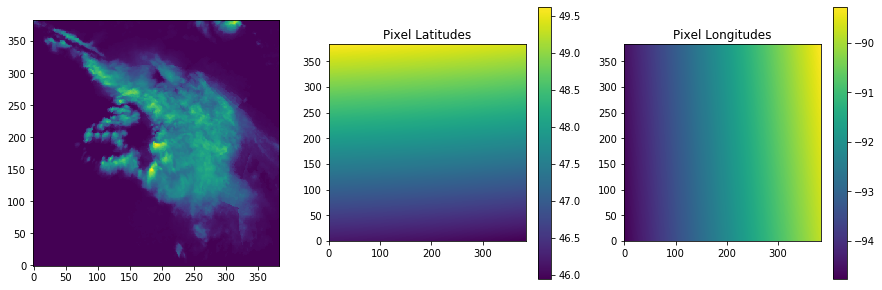

In [9]:
proj = LaeaProjection( sample_event[sample_event.img_type=='vil'].squeeze() )
X,Y = np.meshgrid(np.arange(vil.shape[0]),np.arange(vil.shape[0]))
lons,lats = proj.inverse(X,Y)

# Plot with origin='lower' so up corresponds to north.
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(vil[:,:,20],origin='lower')
la = ax[1].imshow(lats,origin='lower') 
fig.colorbar(la,ax=ax[1]) 
ax[1].set_title('Pixel Latitudes')
lo = ax[2].imshow(lons,origin='lower') 
fig.colorbar(lo,ax=ax[2]) 
ax[2].set_title('Pixel Longitudes')

This particular domain overlaps with north eastern Minnesota.  We can add markers for particular locations by converting from lat/lon coordinates into the image pixel coordinates:

x=200.021527,y=79.057562


Text(170.02152736199426, 49.057561772525304, 'Duluth, MN')

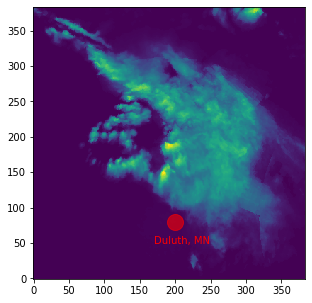

In [18]:
lat,lon = 46.7867, -92.1005 # Duluth, MN
x,y=proj.forward(lon,lat)
print('x=%f,y=%f' % (x,y))
# Plot with origin='lower' so up corresponds to north.
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.imshow(vil[:,:,20],origin='lower')
ax.plot(x,y,linestyle='none', marker="o", markersize=16, alpha=0.6, c="red")
ax.text(x-30,y-30,'Duluth, MN',color='r')

#### Example 4b:   Use Basemap instead

There are a number of python modules that compute these conversions for you, and allow you to visualize the georeferenced result with features like coast lines, state borders and other nice map features.  `pyproj` is a popular module for computing geospatial transformations.  `Basemap` and `Cartopy` are nice plotting libraries.  The cell below shows how perform the georeferencing done in Example 4, but instead using the `Basemap` library:

Text(170021.5273619945, 49057.56177252438, 'Duluth, MN')

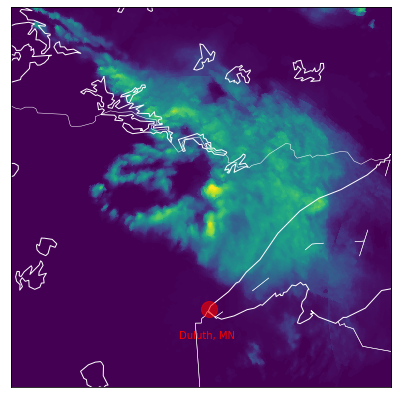

In [22]:
# Note:  Requires basemap module to run
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.basemap import Basemap # conda/pip install basemap basemap-data-hires
# Create Basemap Object
s=sample_event[sample_event.img_type=='vil'].squeeze() 
fig,ax=plt.subplots(1,1,figsize=(7,7))
m = Basemap(llcrnrlat=s.llcrnrlat, llcrnrlon=s.llcrnrlon,
            urcrnrlat=s.urcrnrlat,urcrnrlon=s.urcrnrlon,
            width=s.width_m, height=s.height_m,
            lat_0=38, lon_0=-98,
            projection='laea',
            resolution='i',
            ax=ax)
m.drawstates(color='w')
m.drawcoastlines(color='w')
m.drawcountries(color='w')
m.imshow(vil[:,:,24])

lat,lon = 46.7867, -92.1005 # Duluth, MN
x,y=m(lon,lat) # will be in projection coordinates
m.plot(x,y,linestyle='none', marker="o", markersize=16, alpha=0.6, c="red")
ax.text(x-30e3,y-30e3,'Duluth, MN',color='r')


## Addtional resources <a class="anchor" id="additional"></a>


* NOAA's Storm Event Database:  https://www.ncdc.noaa.gov/stormevents/ftp.jsp
